# Mask R-CNN

This notebook shows how to train a Mask R-CNN object detection and segementation model on a custom coco-style data set.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

sys.path.insert(0, '../libraries')
from mrcnn.config import Config
import mrcnn.utils as utils
import mrcnn.model as modellib
import mrcnn.visualize as visualize
from mrcnn.model import log
import mcoco.coco as coco
import mextra.utils as extra_utils

%matplotlib inline
%config IPCompleter.greedy=True

HOME_DIR = '/home/keras'
DATA_DIR = os.path.join(HOME_DIR, "data/shapes")
MODEL_DIR = os.path.join(DATA_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(HOME_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Dataset

Organize the dataset using the following structure:

```
DATA_DIR
│
└───annotations
│   │   instances_<subset><year>.json
│   
└───<subset><year>
    │   image021.jpeg
    │   image022.jpeg
```

In [3]:
dataset_train = coco.CocoDataset()
dataset_train.load_coco(DATA_DIR, subset="shapes_train", year="2018")
dataset_train.prepare()

dataset_validate = coco.CocoDataset()
dataset_validate.load_coco(DATA_DIR, subset="shapes_validate", year="2018")
dataset_validate.prepare()

dataset_test = coco.CocoDataset()
dataset_test.load_coco(DATA_DIR, subset="shapes_test", year="2018")
dataset_test.prepare()

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


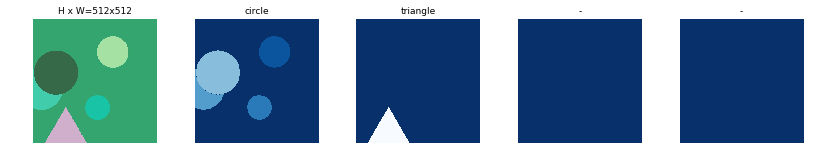

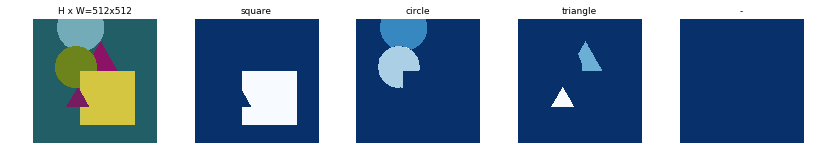

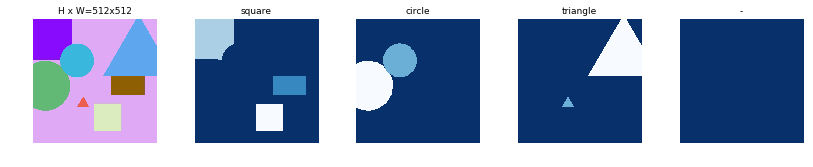

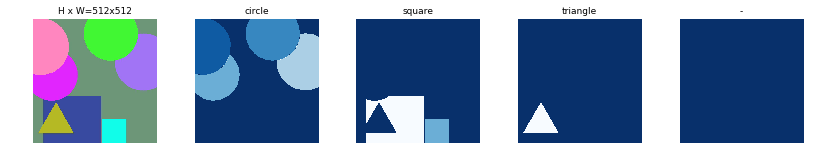

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Configuration

In [5]:
RPN_ANCHOR_TEMPLATE = (1, 2, 4, 8, 16) # anchor sizes in pixels

class ShapesConfig(Config):
    """Configuration for training on the shapes dataset.
    """
    NAME = "shapes"

    # Train on 1 GPU and 2 images per GPU. Put multiple images on each
    # GPU if the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes (triangles, circles, and squares)

    # Use smaller images for faster training. 
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_DIM = 512
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = tuple(i * 32 for i in RPN_ANCHOR_TEMPLATE)

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 200

    VALIDATION_STEPS = STEPS_PER_EPOCH / 20
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MI

# Model


In [ ]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [ ]:
inititalize_weights_with = "coco"  # imagenet, coco, or last

if inititalize_weights_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
    
elif inititalize_weights_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    
elif inititalize_weights_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)


# Training

Training in two stages

## Heads

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

In [ ]:
model.train(dataset_train, dataset_validate, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')

## Fine-tuning

Fine-tune all layers. Pass layers="all to train all layers.

In [ ]:
model.train(dataset_train, dataset_validate, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, # starts from the previous epoch, so only 5 additional are trained 
            layers="all")

# Detection

In [6]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
print(model.find_last()[1])
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



/home/keras/data/shapes/logs/shapes20180421T0559/mask_rcnn_shapes_0005.h5
Loading weights from  /home/keras/data/shapes/logs/shapes20180421T0559/mask_rcnn_shapes_0005.h5


### Test on a random image from the test set

First, show the ground truth of the image, then show detection results.

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (10,)                 min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (10, 4)               min:   28.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 10)        min:    0.00000  max:    1.00000  bool


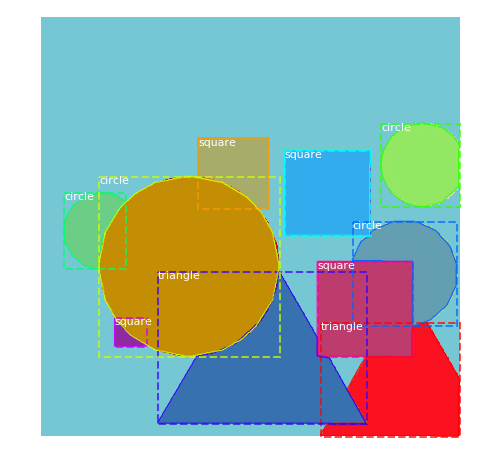

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.80000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


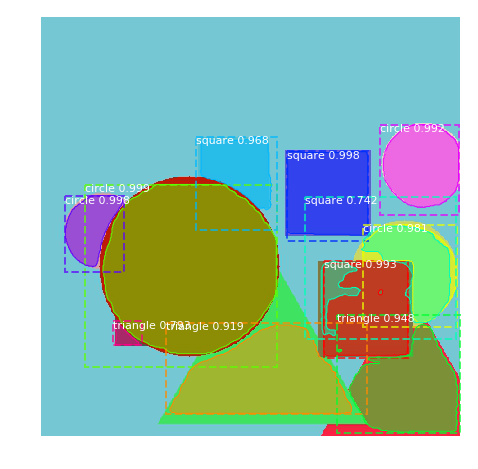

In [7]:
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

# Evaluation

Use the test dataset to evaluate the precision of the model on each class. 

In [9]:
predictions =\
extra_utils.compute_multiple_per_class_precision(model, inference_config, dataset_test,
                                                 number_of_images=250, iou_threshold=0.5)
complete_predictions = []

for shape in predictions:
    complete_predictions += predictions[shape]
    print("{} ({}): {}".format(shape, len(predictions[shape]), np.mean(predictions[shape])))

print("--------")
print("average: {}".format(np.mean(complete_predictions)))

circle (231): 0.9499278507191381
triangle (219): 0.9424911224179797
square (235): 0.8599621765949624
--------
average: 0.9166861325919339
